In [497]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colour import Color
import matplotlib as mpl
from ete3 import Tree, TreeStyle, NodeStyle


In [498]:
# Load all files
main_path = "/var/home/luka/proj/Papilonidae_dataset_v2"
metadata = pd.read_csv(main_path+"/Papilonidae_metadata.txt", sep=",")
landmarks = pd.read_csv(main_path+"/Papilionidae_landmarks.txt", sep="\t", header=None)
aligned = pd.read_csv(main_path+"/Papilionidae_aligned.txt", sep="\t", header=None)

In [499]:
def convert_to_slice(df_subgroup):
    x_coords = df_subgroup[df_subgroup.iloc[:, 1] == "x-coordinates"].iloc[:, 2:].values
    y_coords = -df_subgroup[df_subgroup.iloc[:, 1] == "y-coordinates"].iloc[:, 2:].values
    return np.column_stack((x_coords.ravel(), y_coords.ravel()))

# Split dataframe by "Name" and convert each subgroup back to a 2D slice
groups = [group for _, group in aligned.groupby(aligned.iloc[:, 0])]
list_of_2d_slices = [convert_to_slice(group) for group in groups]
butterflies = np.dstack(list_of_2d_slices)

My work begins here


`#1f77b4, #ff7f0e, #2ca02c, #d62728, #9467bd, #8c564b, #e377c2, #7f7f7f, #bcbd22, and #17becf`

In [500]:
colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf"
]

def plot_wings(marks, sp=plt, cs=colors[:2], leg=None):
    s = 50
    for i in range(2):
        n = [0,s][i]
        c = cs[i]
        xs = marks[n:s+n, 0]
        ys = -marks[n:s+n, 1]
        if leg and not i:
            sp.plot(xs, ys,color=c,label=leg)
        else:
            sp.plot(xs, ys,color=c)
    sp.axis("equal")

    if leg:
        sp.legend()

In [501]:
def plot_wings_simple(marks, sp=plt,leg=None):
    s = 50
    for n in [0,s]:
        xs = marks[n:s+n, 0]
        ys = -marks[n:s+n, 1]
        if leg is not None and n==0:
            sp.plot(xs, ys,label=leg)
        else:
            sp.plot(xs, ys)
    sp.axis("equal")
    if leg is not None:
        sp.legend()

In [502]:
colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf"
]

def plot_points(marks, cols=4, titles=None):
    (_,_,n) = marks.shape
    if titles is None or len(titles) != n:
        titles = [str(i) for i in range(n)]
    (rows,rest) = np.divmod(n, cols)

    f = plt.figure(figsize=(rows*2, cols*12))
    for i in range(cols*rows):

        sp = plt.subplot(rows, cols, i + 1)
        plt.title(titles[i])
        plot_wings(marks[:, :, i],sp)

def compare_plot_points(marks1,marks2, cols=4,titles=None,legs=(None,None)):
    (_,_,n) = marks1.shape
    if titles is None or len(titles) != n:
        titles = [str(i) for i in range(n)]
    (rows,rest) = np.divmod(n, cols)

    f = plt.figure(figsize=(rows*2, cols*12))
    for i in range(cols*rows):

        sp = plt.subplot(rows, cols, i + 1)
        plt.title(titles[i])
        plot_wings(marks1[:, :, i],sp,['red']*2,leg=legs[0])
        plot_wings(marks2[:, :, i],sp,['blue']*2,leg=legs[1])


def compare_more_points(marksList, cols=4,titles=None,legs=(None,None)):
    (_,_,n) = marksList[0].shape
    s = len(marksList)

    #for var in [titles, legs]:
    if legs is None or len(legs) != s:
        print(legs,s)
        legs = [str(i) for i in range(s)]
    if titles is None or len(titles) != n: titles = [str(i) for i in range(n)]


    (rows,rest) = np.divmod(n, cols)

    f = plt.figure(figsize=(rows*2, cols*12))
    for i in range(cols*rows):

        sp = plt.subplot(rows, cols, i + 1)
        plt.title(titles[i])
        for j in range(s):
            plot_wings(marks=marksList[j][:, :, i],sp=sp,cs=[colors[j]]*2,leg=legs[j])

In [503]:
print(colors[0])

#1f77b4


In [504]:
all_species = metadata["species"].unique()
num_species = len(all_species)

(p,q,_) = butterflies.shape
mean_butterflies = np.zeros((p,q,num_species))
names = []

for i in range(num_species):
    s = all_species[i]
    names.append(s)
    idx = metadata["species"]==s
    collection = butterflies[:, :, idx]
    mean_specimen = np.mean(collection, axis=2)
    mean_butterflies[:,:,i] = mean_specimen


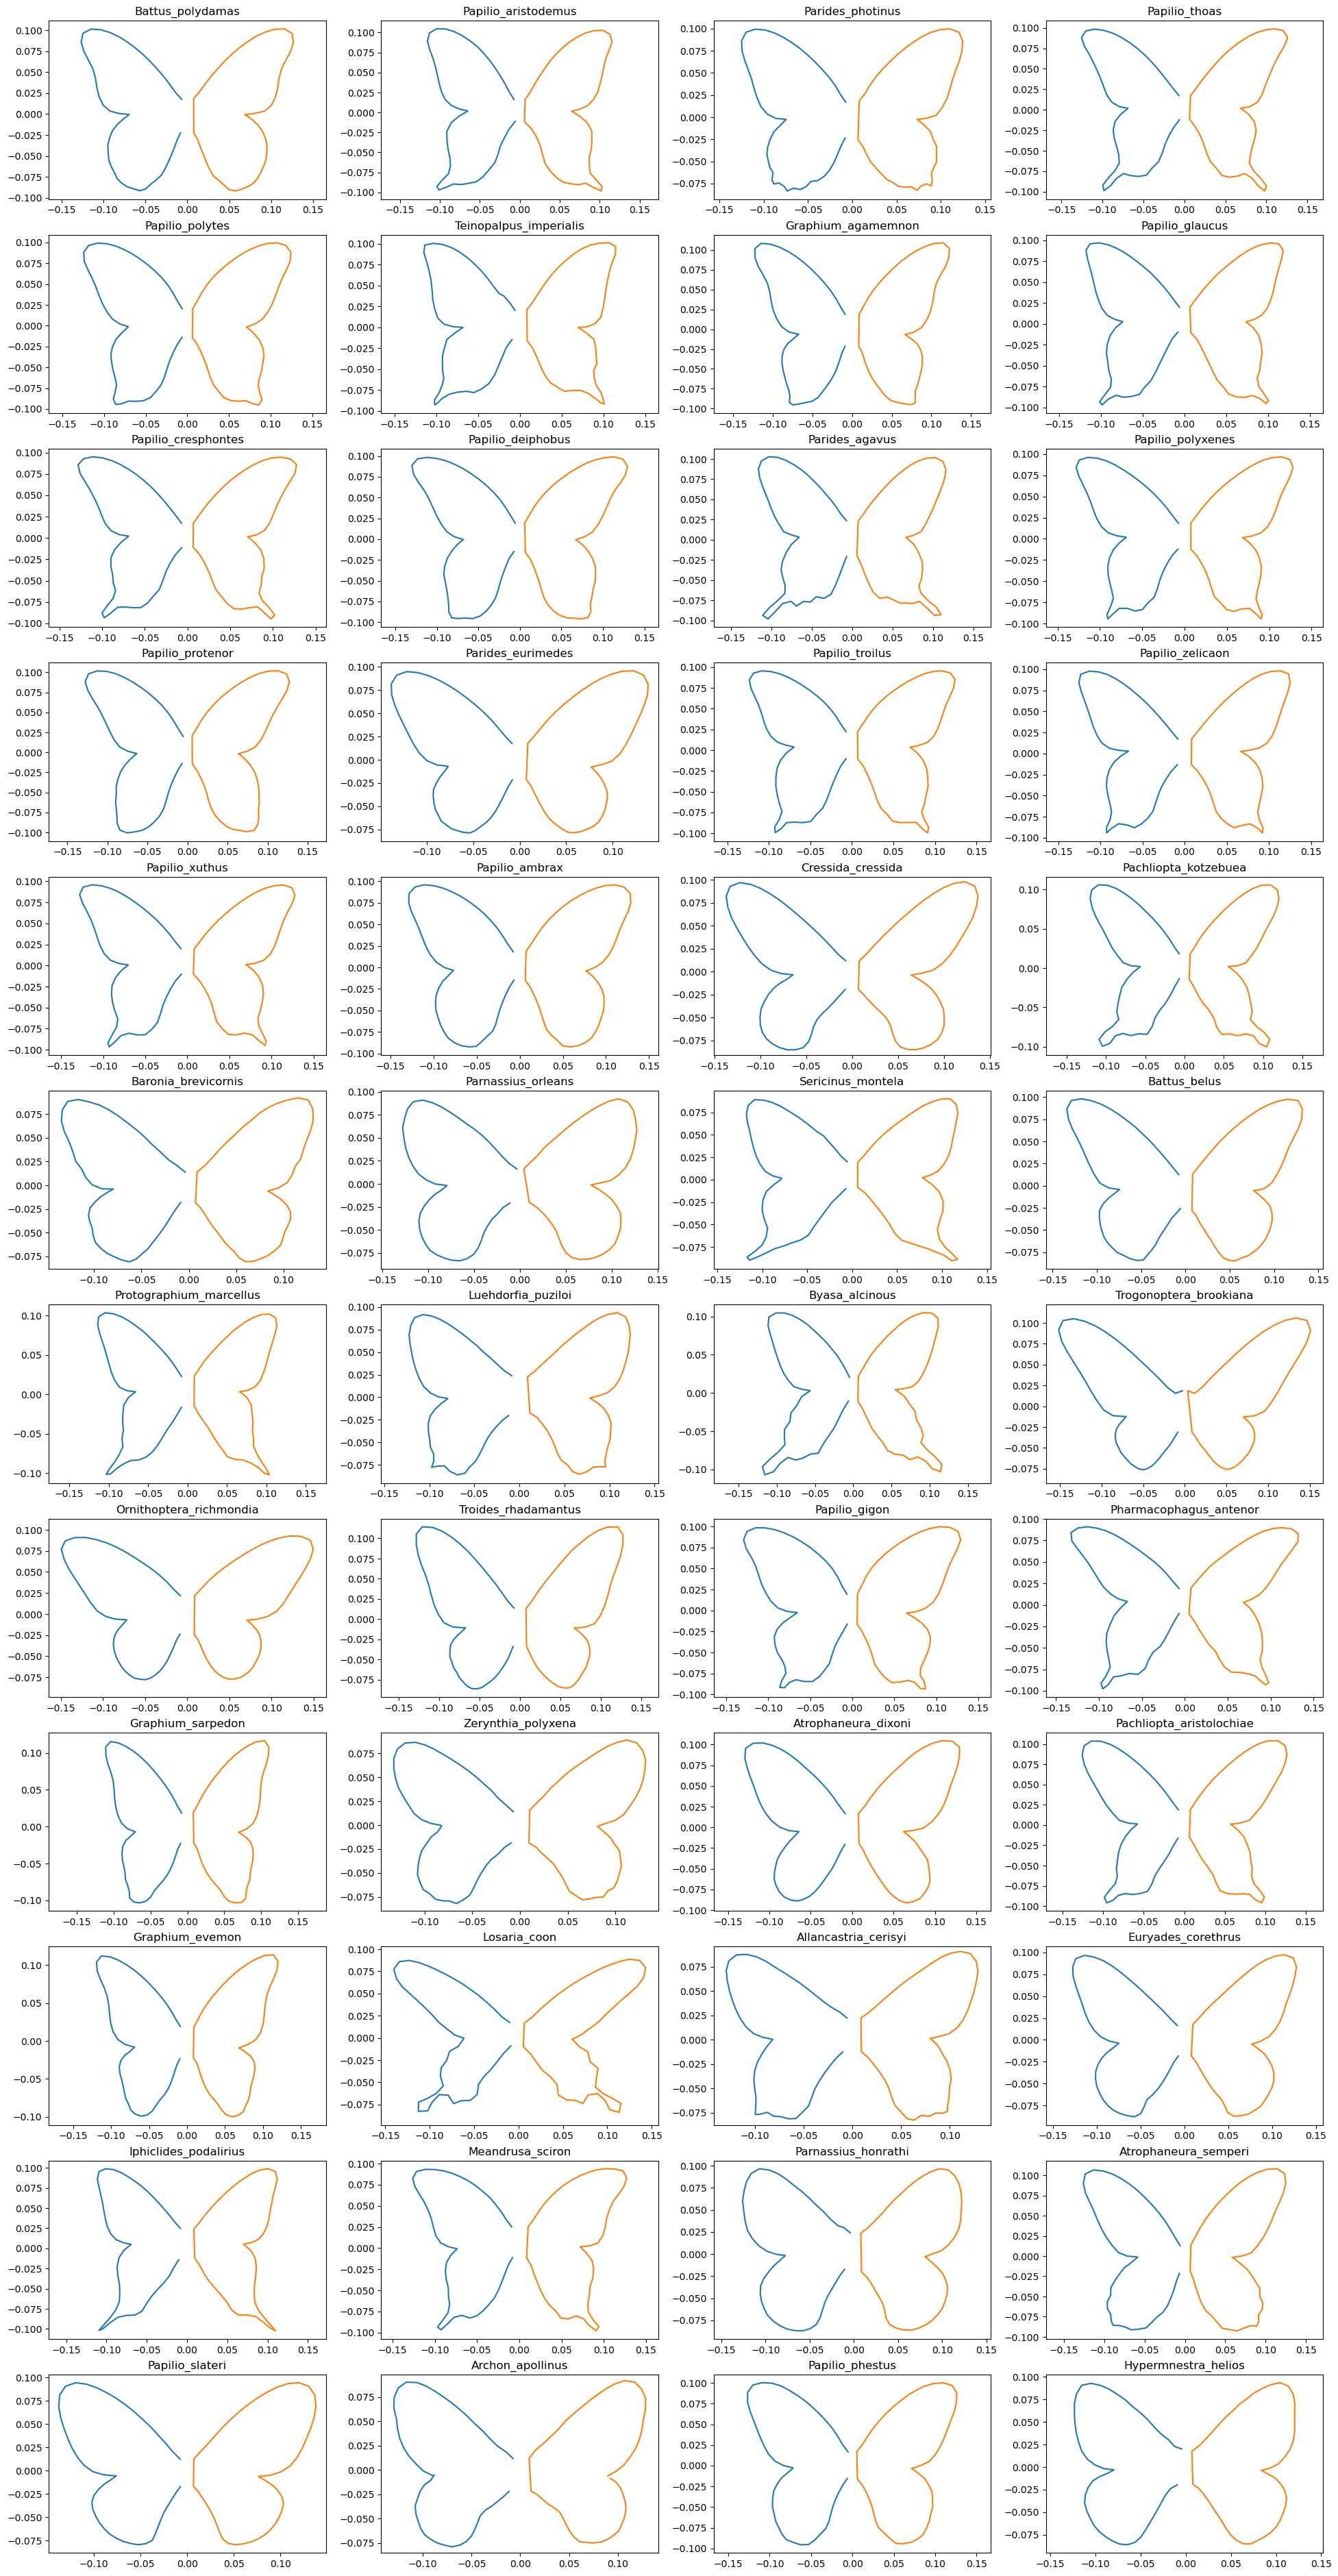

In [505]:
plot_points(mean_butterflies,cols=4,titles=names)

In [506]:
def flat(marks):
    dims = len(marks.shape)
    if dims == 2:
        print("called flat() on 2d array, nothing happened.")
        return marks.reshape(marks.shape[0]*marks.shape[1])
    elif dims == 3:
        return marks.reshape(marks.shape[0]*marks.shape[1], marks.shape[2])
    else:
        raise ValueError("Invalid number of dimensions")

def unflat(marks, d=2):
    dims = len(marks.shape)
    if dims == 1:
        return marks.reshape(marks.shape[0]//d, d)
    elif dims == 2:
        return marks.reshape(marks.shape[0]//d, d, marks.shape[1])
    else:
        raise ValueError("Invalid number of dimensions")
    


Results of code below: data is Procrustes superimposed to remove translation and rotation, but not removing scale differences (RMSD differs). 

In [507]:
def rmsd(b):
    (k,two) = b.shape
    if (two != 2) or (k%2 != 0): raise ValueError("Invalid dimensions")
    s = 0.
    
    (xm, ym) = np.mean(b, axis=0)
    ms = [xm, ym]
    
    for i in [0,1]:
        if abs(ms[i]) < 1e-10:
            s += np.sum(np.square(b[i]))
        else:
            print("!")
            s += np.sum(np.square(np.add(b[i], ms[i])))
    
    return np.sqrt(s)/k



In [508]:
# data is already centered
for i in range(num_species):
    b = mean_butterflies[:, :, i]
    print(np.mean(b, axis=0),'\t',rmsd(b))




[-5.82867088e-18 -3.46511014e-18] 	 0.0003501167292059196
[ 1.2490009e-18 -1.6956922e-18] 	 0.00033808968278441106
[-6.38378239e-18  4.51028104e-19] 	 0.00034769422714547865
[-4.99600361e-18 -4.31512465e-18] 	 0.0003474517294619978
[8.74300632e-18 1.25550612e-18] 	 0.00038233661850611513
[ 9.15933995e-18 -3.50305722e-18] 	 0.00038586168901683473
[-5.41233725e-18 -4.91794105e-18] 	 0.0003815227818878251
[1.15185639e-17 8.62157568e-18] 	 0.000369358179760641
[ 1.11022302e-18 -4.14165230e-19] 	 0.0003461911557620005
[-4.71844785e-18  9.83588211e-18] 	 0.0003665428404956639
[-1.41553436e-17 -2.05998413e-18] 	 0.000422689190253513
[1.56819002e-17 6.74373751e-18] 	 0.0003654168931160725
[-8.32667268e-18 -9.87925020e-18] 	 0.0003765993857626297
[9.71445147e-19 6.78276879e-18] 	 0.000360690489492908
[-1.06858966e-17  9.41087486e-19] 	 0.00040836100025829235
[2.49800181e-18 5.70290343e-18] 	 0.0003515476812496767
[9.71445147e-18 6.21789946e-18] 	 0.00038232958921164344
[-1.34614542e-17 -4.59701

# Traditional PCA

In [509]:
X = flat(mean_butterflies).T

X_mean = np.mean(X, axis=0)
X_cent = X - X_mean[None,:]
# get eigenvectors and eigenvalues from covariance matrix
Cov = np.cov(X_cent)
evals, evecs = np.linalg.eigh(Cov)

In [510]:
print(Cov.shape)
print(X_cent.shape)

(48, 48)
(48, 200)


In [511]:
(m,n) = X.shape
rank = np.linalg.matrix_rank(X)
print(f'{m}\ttraits')
print(f'{rank}\trank')
print(f'{m-rank}\tdegrees of freedom removed' )

48	traits
48	rank
0	degrees of freedom removed


k         Proportion of variance explained by the first k principal components
1         0.47255641329531933
2         0.7414733442543575
3         0.8530112269744471
4         0.9001848103453937
5         0.9317659590506975
6         0.946649915630929
7         0.9591728990563367
8         0.967773935677849
9         0.9745761706155933
10        0.9796775488170287
11        0.9837313771812707
12        0.9865598811439669
13        0.988573344906979
14        0.9904090454405178
15        0.9919231467167611
16        0.9931095116326686
17        0.9941897383143994
18        0.9949905947045756
19        0.9956385273328618
20        0.9962623489981802
21        0.9967566763789023
22        0.9971757663475553
23        0.997530457345114
24        0.9978811473701547
25        0.9981471040136617
26        0.9983953167406779
27        0.9986249125333454
28        0.9988395068174923
29        0.9990206292088732
30        0.9991843826171325
31        0.9993245458534439
32        0.9994504451379

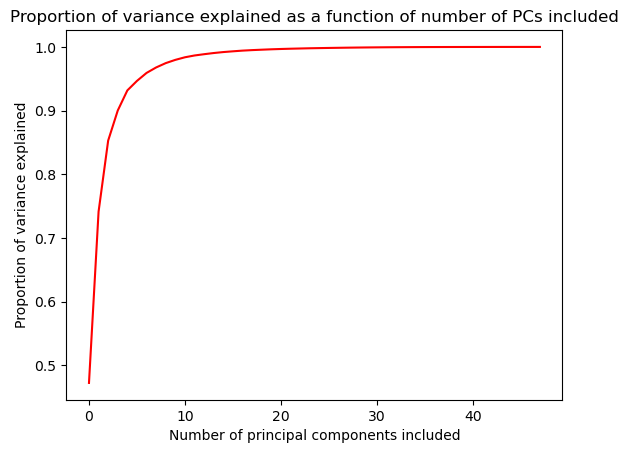

In [519]:
# variance explained by first k components
vars = evals[::-1]/np.sum(evals)                # variance explained per component
cVars = np.cumsum(vars) # cumulative variance explained

plt.plot(cVars[:num_species])
plt.xlabel('Number of principal components included')
plt.ylabel('Proportion of variance explained')
plt.title('Proportion of variance explained as a function of number of PCs included')

# Let's print out the proportion of variance explained by the first 10 PCs
print(f'{"k":<10}Proportion of variance explained by the first k principal components')
for i in range(num_species):
    print(f'{i+1:<10}{cVars[i]}')

In [513]:
def pca_transform(k=1,w=1.):
    evec_k = evecs[:, -k]
    eval_k = evals[-k]

    modarr = np.ones(num_species)
    modarr[-k] = w
    #print(modarr)
    #d = (evals[-1] - eval_k)*dmul
    #std = eval_k ** -0.85 + d
    #dev = std*w
    #print(dev)
    #ek_space = dev * (evec_k @ Cov)
    V_mod = np.multiply(evec_k,modarr)

    print(X_cent.shape,V_mod.shape)
    t1 = X_cent.T @ V_mod
    print(t1.shape)
    t2 = t1 @ V_mod.T
    print(t2.shape, X_mean.shape)
    X_mod =  t2 + X_mean
    #X_mod_mean = np.mean(X_mod, axis=0)
    #print(X_mod_mean.shape)
    return X_mod

In [514]:
k=2
V_k = evecs[:, -k:]
t =  V_k @ (V_k.T)
print(t.shape)

(48, 48)


In [515]:
def pca_recon(k=2):
    V_k = evecs[:, -k:]
    #print(X_cent.shape,V_k.shape)
    X_reduced = X_cent.T @ V_k
    #print(X_reduced.shape)
    X_reconstructed = X_reduced @ V_k.T + X_mean[:,None]
    #print(V_k.shape,X_cent.shape,X_reduced.shape,X_reconstructed.shape)
    #print(X_reconstructed.shape)
    return unflat(X_reconstructed)

In [516]:
reconA=pca_recon(k=2)

#compare_plot_points(mean_butterflies,reconA,cols=4,titles=names,legs=("original","reconstructed"))

In [517]:
# get eigenvectors and eigenvalues from covariance matrix
P2 = ((n - 1) ** (
    -1) * X_cent) @ X_cent.T  # a little more precise than P3 when comparing to P1 (less floating point loss)
P3 = ((n - 1) ** (-1)) * (X_cent @ X_cent.T)  # a liitle more precise than P2 when checking symmetry

A = Cov - P2
tolA = A.flat[abs(A).argmax()]

B = Cov - P3
tolB = B.flat[abs(B).argmax()]

limit = 1e-11
print("P2")
print("tolerance:\t\t",tolA)
print(f'< limit {limit}:\t', np.allclose(Cov, P2, limit, 0.))
print("symmetric:\t\t",(np.array_equal(P2, P2.T)))


print("\nP3")
print("tolerance:\t\t",tolB)
print(f'< limit {limit}:\t', np.allclose(Cov, P3, limit, 0.))
print("symmetric:\t\t",(np.array_equal(P3, P3.T)))





P2
tolerance:		 -8.131516293641283e-20
< limit 1e-11:	 True
symmetric:		 False

P3
tolerance:		 3.3881317890172014e-20
< limit 1e-11:	 True
symmetric:		 True


In [518]:
e1, _ = np.linalg.eigh(Cov)
ej, _ = np.linalg.eig(Cov)
#diff = (evals - S)

#print((e1-S1)[0])
#print((e3-S3)[0])
k = n
nn = n-1
ejr = np.flip(ej)

for i in range(200):
    a = (e1[i])
    b = (np.real(ejr[i]))
    d = a-b
    if abs(d) > limit:
        print(f'\n!{i:3d}\t{a:9.9f}\t\t{b:9.9f}\t{np.imag(ejr[i]):9.9f}\n')
    print(f'{i:3d}\t\t{a:9.9f}\t\t{b:9.9f}\t\t{abs(a-b):9.9f}')

#print(np.allclose(evals, S, 1e-8, 0.))
# F print(np.array_equal(evals[:10],S[:10]))
# F rint((np.array_equal(S, evals)))
#print(np.allclose(S[:20], evals[:20], 1e-10, 0.))


!  0	0.000000000		0.000000032	0.000000000

  0		0.000000000		0.000000032		0.000000032

!  1	0.000000008		0.000000030	0.000000000

  1		0.000000008		0.000000030		0.000000021

!  2	0.000000017		0.000000037	0.000000000

  2		0.000000017		0.000000037		0.000000019

!  3	0.000000021		0.000000040	0.000000000

  3		0.000000021		0.000000040		0.000000020

!  4	0.000000030		0.000000046	0.000000000

  4		0.000000030		0.000000046		0.000000016

!  5	0.000000032		0.000000021	0.000000000

  5		0.000000032		0.000000021		0.000000011

!  6	0.000000037		0.000000017	0.000000000

  6		0.000000037		0.000000017		0.000000019

!  7	0.000000040		0.000000053	0.000000000

  7		0.000000040		0.000000053		0.000000012

!  8	0.000000046		0.000000008	0.000000000

  8		0.000000046		0.000000008		0.000000037

!  9	0.000000053		0.000000065	0.000000000

  9		0.000000053		0.000000065		0.000000013

! 10	0.000000065		-0.000000000	0.000000000

 10		0.000000065		-0.000000000		0.000000065
 11		0.000000080		0.000000080		0.00000000

IndexError: index 48 is out of bounds for axis 0 with size 48

In [318]:
e1 = evals[-1]

for i in range(1,13):
    e = evals[-i]
    d = e1-e
    la = e ** -0.2
    print(f'{i:2d}\t{e*1000:9.6f}\t{la:9.6f}\t{la+d*2000:9.6f}')

 1	 3.754382	 3.055570	 3.055570
 2	 2.136500	 3.420262	 6.656026
 3	 0.886150	 4.078482	 9.814946
 4	 0.374786	 4.844436	11.603628
 5	 0.250907	 5.249252	12.256203
 6	 0.118251	 6.101539	13.373802
 7	 0.099493	 6.315991	13.625769
 8	 0.068334	 6.808836	14.180933
 9	 0.054043	 7.135965	14.536644
10	 0.040530	 7.558673	14.986378
11	 0.032207	 7.914254	15.358604
12	 0.022472	 8.504948	15.968769


In [467]:
K=6
ks = [i for i in range(1,K+1)]
v = 3
w = 2*v + 1
s = 0.1
a = np.arange((1-v*s),(1+v*s),s)
#print(a,len(a))

t1 = pca_transform(k=1,w=1.)
t2 = pca_transform(k=1,w=2.)
print(t1-X_mean)

(48, 200) (48,)
(200,)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 48 is different from 200)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 48 is different from 200)

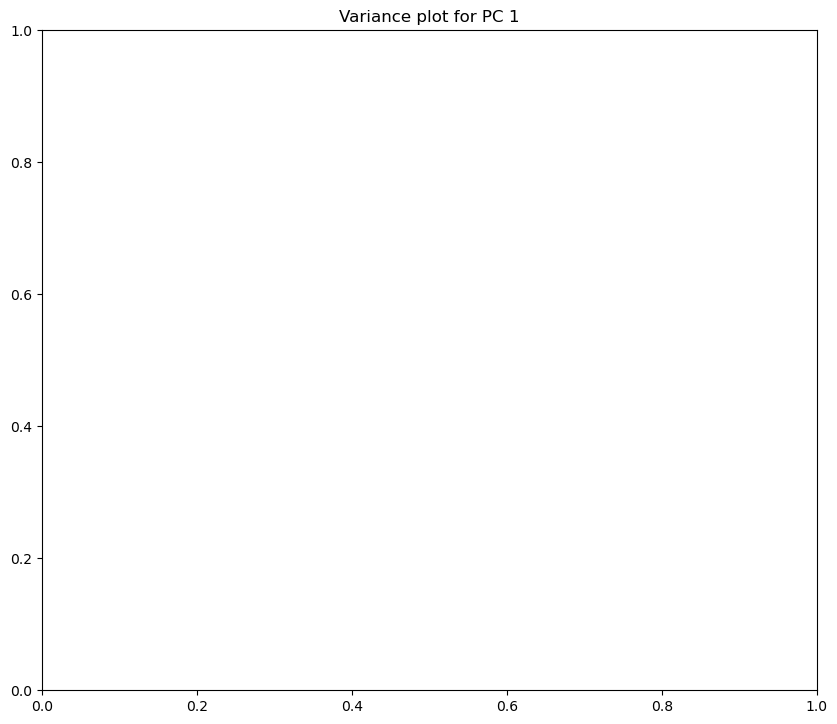

In [428]:



gradient = list(Color("red").range_to(Color("green"), res))
grad = [c.get_hex() for c in gradient]


plt.figure(figsize=(10, 10*K))

for k in ks:
    sp = plt.subplot(K,1,k)
    sp.set_title('Variance plot for PC '+str(k))
    for i in range(res):

        X_k_i = pca_transform(k=k,w=a[i])
        print((X_mean - X_k_i))
        plot_wings(marks=unflat(X_k_i),sp=sp,cs=[grad[i]]*2,leg=f'{a[i]}')
    print('\n')


In [535]:
K=6
dmul = 1200
ks = [i for i in range(1,K+1)]
v = 3
a = np.arange(-v,v+1)
res = 2*v+1
gradient = list(Color("red").range_to(Color("green"), res))
grad = [c.get_hex() for c in gradient]

#U, S, Vh = np.linalg.svd(Cov, hermitian=True)
#Sig = np.diag(S)
#Scores = X_cent.T @ U
plt.figure(figsize=(10, 10*K))

for k in ks:
    evec_k = evecs[:, -k]
    eval_k = evals[-k]
    #d = (e1 - eval_k)*dmul
    std = eval_k ** -0.25 #+ d

    ek_space = std * (evec_k @ Cov)
    # modify data by devs[i] standard deviations of ek_space
    devs = std * a

    print(X_mean.shape, devs.shape, Cov.shape,evec_k.shape,ek_space.shape)
    tmp = devs[:,None]*ek_space
    print(tmp.shape)
    X_along_pc = X_mean + tmp

    sp = plt.subplot(K,1,k)
    sp.set_title('Variance plot for PC '+str(k))
    for i in range(res):
        plot_wings(marks=unflat(X_along_pc[i]),sp=sp,cs=[grad[i]]*2,leg=f'{a[i]}')

(200,) (7,) (48, 48) (48,) (48,)
(7, 48)


ValueError: operands could not be broadcast together with shapes (200,) (7,48) 

<Figure size 1000x6000 with 0 Axes>

# Phylogenetic PCA

In [320]:
all_species = metadata["species"].unique()
num_species = len(all_species)

(p,q,_) = butterflies.shape
mean_butterflies = np.zeros((p,q,num_species))

for i in range(num_species):
    s = all_species[i]
    names.append(s)
    idx = metadata["species"]==s
    collection = butterflies[:, :, idx]
    mean_specimen = np.mean(collection, axis=2)
    mean_butterflies[:,:,i] = mean_specimen

ptree = Tree(main_path+"/papilionidae_tree.txt",format=1)
root = ptree.name
print(ptree)
for i in range(num_species):
    print(i,'\t',names[i])


   /-Baronia_brevicornis
  |
  |      /-Iphiclides_podalirius
  |     |
  |   /-|      /-Graphium_evemon
  |  |  |   /-|
  |  |  |  |  |   /-Graphium_sarpedon
  |  |   \-|   \-|
--|  |     |      \-Graphium_agamemnon
  |  |     |
  |  |      \-Protographium_marcellus
  |  |
  |  |         /-Hypermnestra_helios
  |  |      /-|
  |  |     |  |   /-Parnassius_orleans
  |  |     |   \-|
  |  |     |      \-Parnassius_honrathi
   \-|   /-|
     |  |  |      /-Archon_apollinus
     |  |  |   /-|
     |  |  |  |   \-Luehdorfia_puziloi
     |  |   \-|
     |  |     |   /-Sericinus_montela
     |  |      \-|
     |  |        |   /-Zerynthia_polyxena
     |  |         \-|
     |  |            \-Allancastria_cerisyi
     |  |
     |  |   /-Teinopalpus_imperialis
     |  |  |
      \-|  |         /-Battus_polydamas
        |  |      /-|
        |  |     |   \-Battus_belus
        |  |     |
        |  |     |   /-Pharmacophagus_antenor
        |  |     |  |
        |  |   /-|  |         /-Trogono

In [321]:
X = flat(mean_butterflies)
(d,N)   = X.shape
D       = np.zeros((N*d,d))

for i in range(N*d):
    for j in range(d):
        if (j-1)*N < i >= j*N:
            D[i,j] = 1.


In [322]:

def ecov(a,b):
    na,nb = names[a],names[b]
    if a == b:
        mrca = ptree.search_nodes(name=names[a])[0]
    else:
        mrca = ptree.get_common_ancestor(na,nb)

    dist = ptree.get_distance(mrca)
    print(f'{na:>30}\t{nb:>30}\t{mrca.name:>30}\t{dist}\n')

    return dist

In [323]:
evoCov = np.empty((num_species,num_species))

for i in range(num_species):
    for j in range(num_species):
        evoCov[i,j] = ecov(i,j)

              Battus_polydamas	              Battus_polydamas	              Battus_polydamas	0.25465000000000004

              Battus_polydamas	           Papilio_aristodemus	                        QS1833	0.09689

              Battus_polydamas	              Parides_photinus	                        QS1834	0.13101

              Battus_polydamas	                 Papilio_thoas	                        QS1833	0.09689

              Battus_polydamas	               Papilio_polytes	                        QS1833	0.09689

              Battus_polydamas	        Teinopalpus_imperialis	                        QS1832	0.08284

              Battus_polydamas	            Graphium_agamemnon	                        QS1804	0.04527

              Battus_polydamas	               Papilio_glaucus	                        QS1833	0.09689

              Battus_polydamas	           Papilio_cresphontes	                        QS1833	0.09689

              Battus_polydamas	             Papilio_deiphobus	        

![MLE](3-4.png)

In [324]:
math_X = X.T
(N,d) = math_X.shape
assert N==num_species and d==200

v1 = np.ones(num_species)
evoCov_inv = np.linalg.inv(evoCov)
tmp = v1.T @ evoCov_inv
mle_r = ((tmp @ v1) **-1) * (tmp @ math_X)
assert mle_r.shape==(d,)

tmp = math_X - mle_r.T
mle_R = (((num_species - 1) ** -1) * tmp.T) @ evoCov_inv @ tmp
assert mle_R.shape==(d,d)


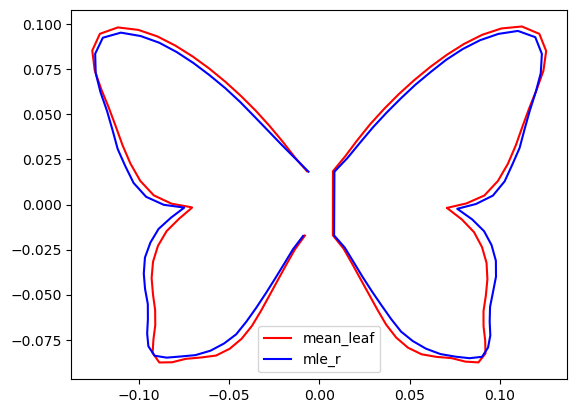

In [325]:
mean_leaf = np.mean(X,axis=1)
plot_wings(marks=unflat(mean_leaf),sp=plt,cs=['red']*2,leg='mean_leaf')
plot_wings(marks=unflat(mle_r),sp=plt,cs=['blue']*2,leg='mle_r')



![MLE2](3-4-ex.png)

Proportion of variance exlained by first k PCs, using PCA and pPCA
k    PCA       pPCA      
1    0.4726    0.4423
2    0.7415    0.5901
3    0.8530    0.6620
4    0.9002    0.7107
5    0.9318    0.7399
6    0.9466    0.7633
7    0.9592    0.7844
8    0.9678    0.8001
9    0.9746    0.8144
10   0.9797    0.8275
11   0.9837    0.8396
12   0.9866    0.8507
13   0.9886    0.8613
14   0.9904    0.8707
15   0.9919    0.8799
16   0.9931    0.8888
17   0.9942    0.8972
18   0.9950    0.9055
19   0.9956    0.9134
20   0.9963    0.9207
21   0.9968    0.9272
22   0.9972    0.9336
23   0.9975    0.9396
24   0.9979    0.9442
25   0.9981    0.9488
26   0.9984    0.9532
27   0.9986    0.9568
28   0.9988    0.9603
29   0.9990    0.9637
30   0.9992    0.9670
31   0.9993    0.9703
32   0.9995    0.9733
33   0.9996    0.9762
34   0.9996    0.9790
35   0.9997    0.9817
36   0.9998    0.9844
37   0.9998    0.9867
38   0.9998    0.9889
39   0.9999    0.9909
40   0.9999    0.9929
41   0.9999    0.9946
42   

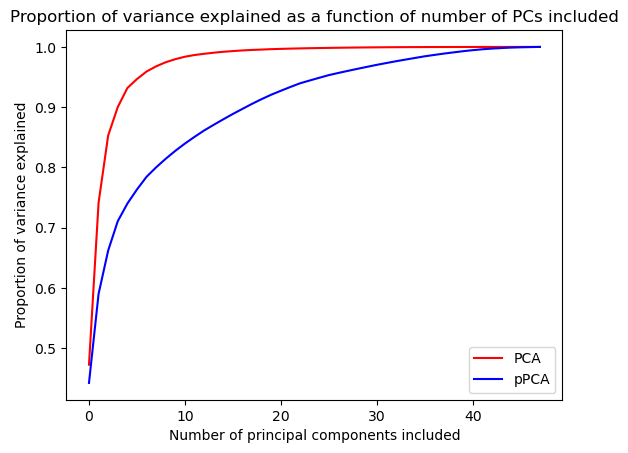

In [534]:
#print(Cov.shape,evoCov.shape) fixed now

evoEvals, evoEvecs = np.linalg.eigh(evoCov)

# variance explained by first k components
vars = evoEvals[::-1]/np.sum(evoEvals)                # variance explained per component
evoCvars = np.cumsum(vars) # cumulative variance explained


plt.plot(cVars,color='red',label="PCA")
plt.plot(evoCvars,color='blue',label="pPCA")
plt.legend()

plt.xlabel('Number of principal components included')
plt.ylabel('Proportion of variance explained')
plt.title('Proportion of variance explained as a function of number of PCs included')


# Let's print out the proportion of variance explained by the first 10 PCs
print("Proportion of variance exlained by first k PCs, using PCA and pPCA")
print(f'{"k":5}{"PCA":10}{"pPCA":10}')
for i in range(num_species):
    print(f'{i+1:<5}{cVars[i]:6.4f}{evoCvars[i]:10.4f}')


less explained by first k PCs...
discussion points:
could this be good? is regular PCA overfitting?
this covariance matrix has fewer bits of information - (d,d), not (N,N) - so comparing them this way is unfair


In [492]:
def ppca_recon(k=2):
    V_k = evoEvecs[:, -K:]
    #print(X_cent.shape,V_k.shape)
    X_reduced = X_cent.T @ V_k
    #print(X_reduced.shape)
    X_reconstructed = X_reduced @ V_k.T + X_mean[:,None]
    #print(X_reconstructed.shape)
    return unflat(X_reconstructed)

Reconstruction with 8 principal components


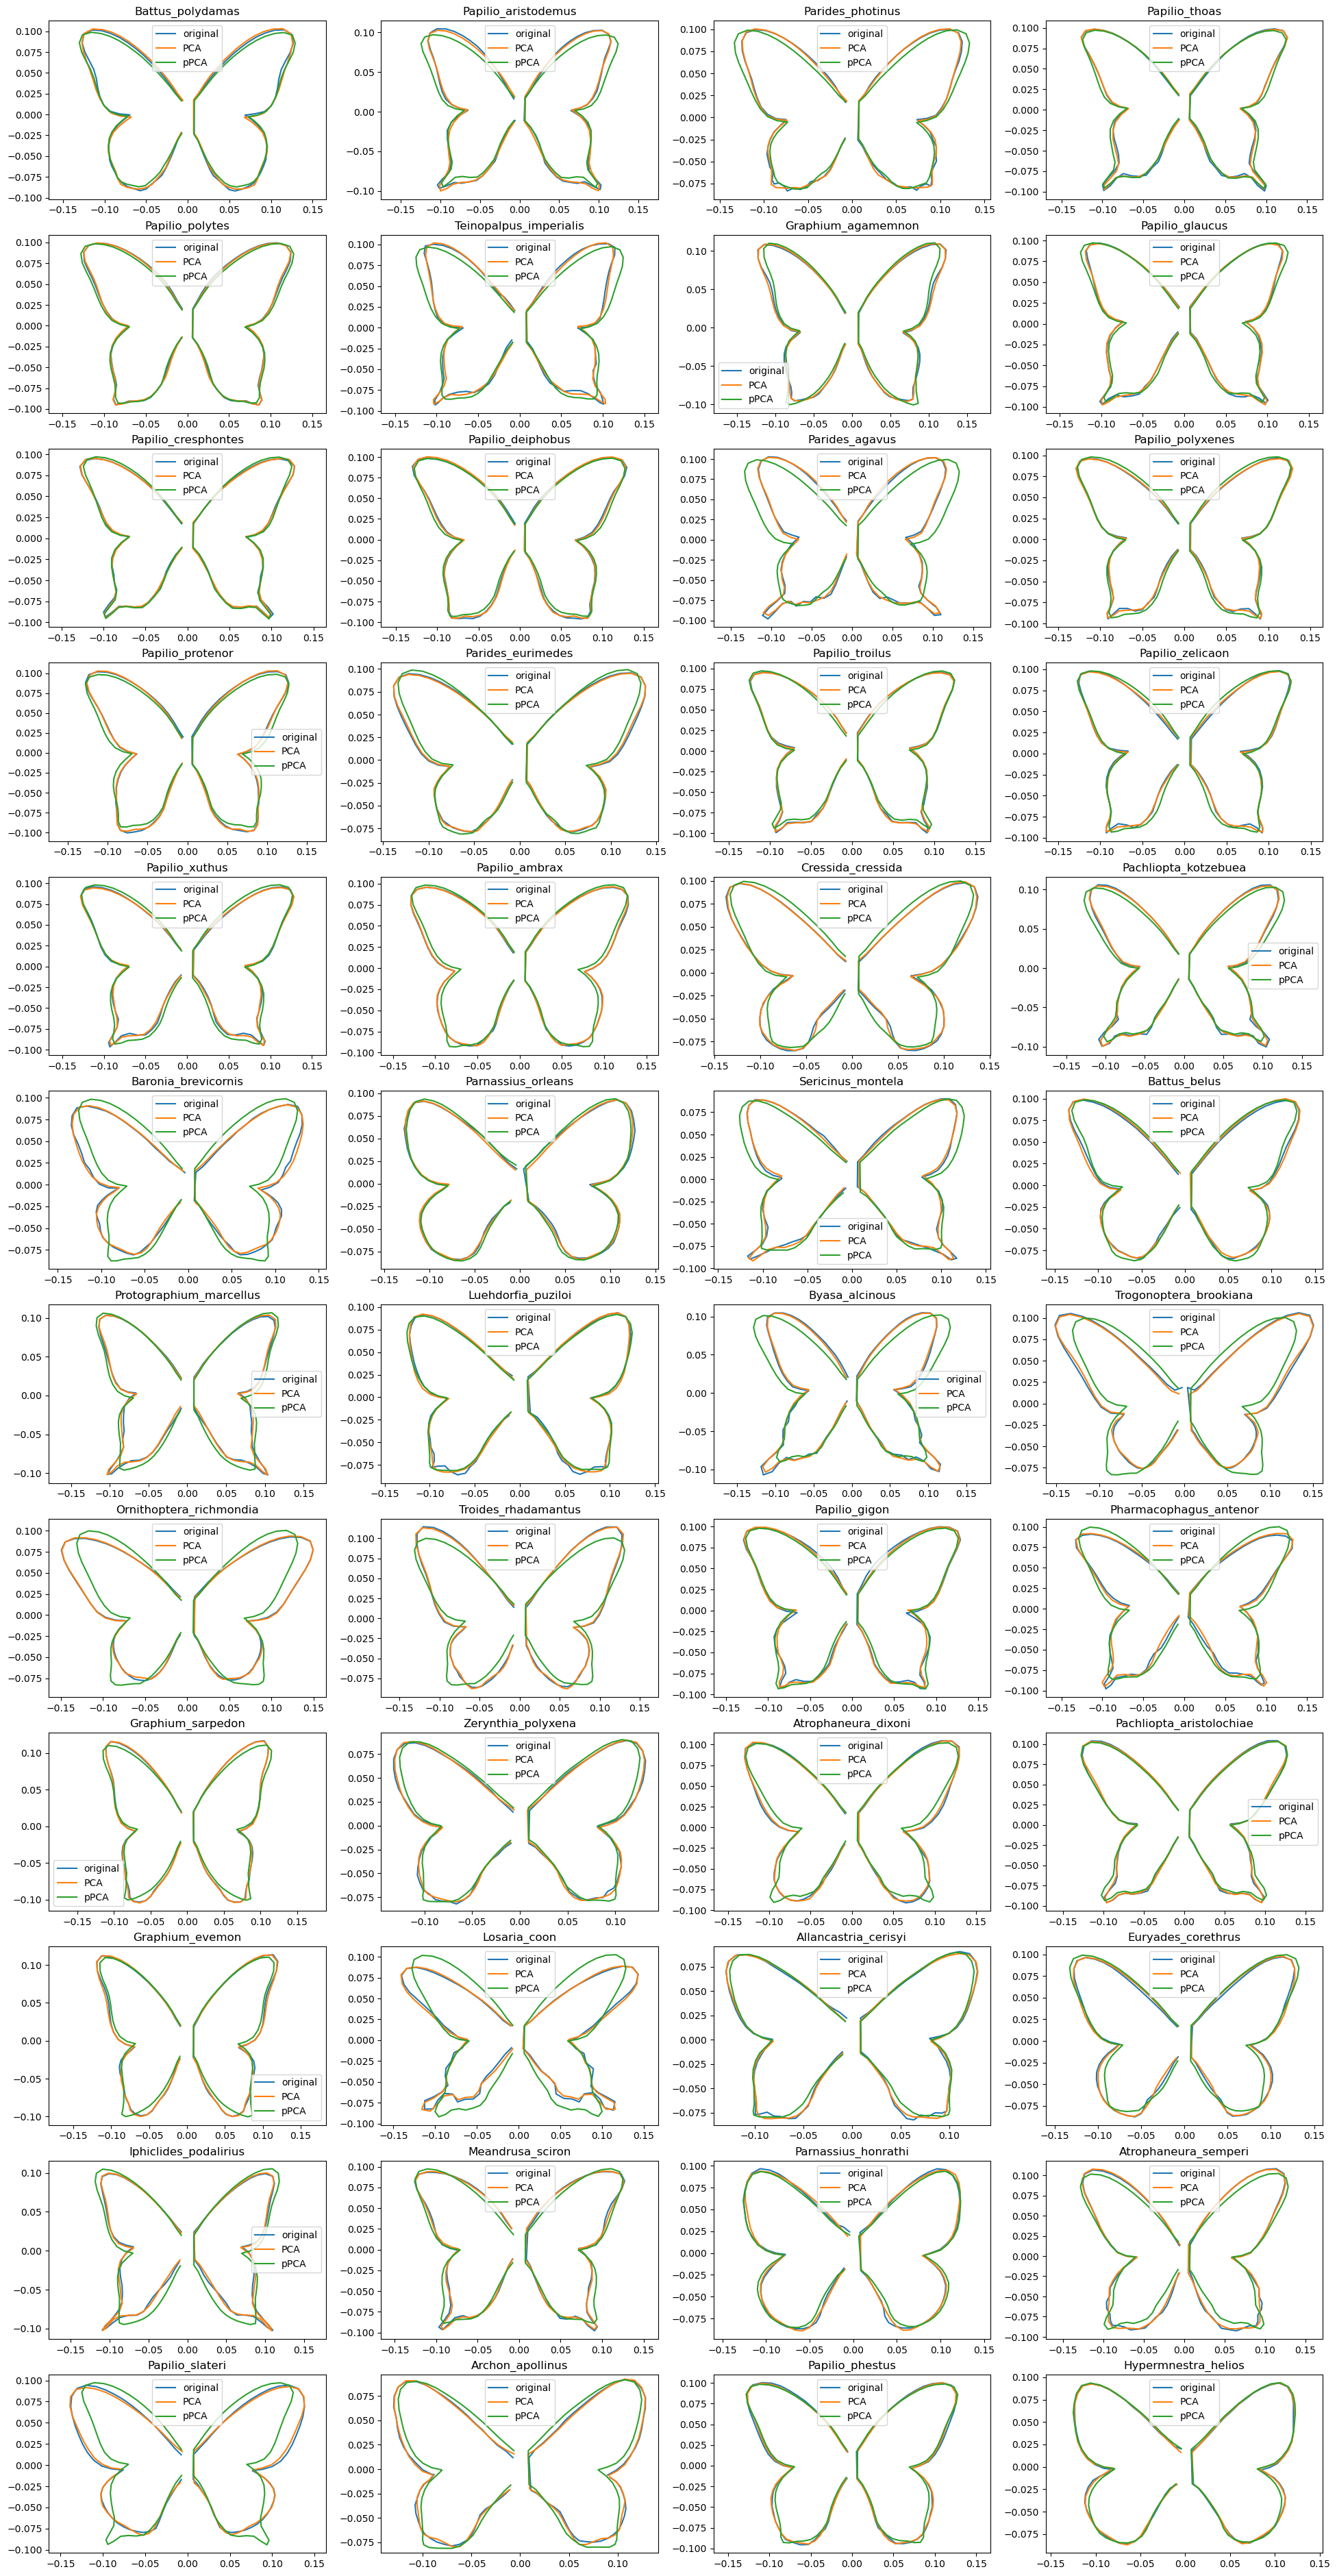

In [496]:
K=8

reconA = pca_recon(K)
reconB = ppca_recon(K)
print(f'Reconstruction with {K} principal components')
compare_more_points(marksList=[mean_butterflies,reconA,reconB],cols=4,titles=names,legs=["original","PCA","pPCA"])